STEP 3:
    Feature Training

In [ ]:
import pandas as pd
df = pd.read_csv('datasets/cleaned_emi_data.csv')

In [ ]:
df = pd.read_csv('datasets/cleaned_emi_data.csv')
df['age'].fillna(df['age'].median(), inplace=True)

C:\Users\Tasneem Inayath\AppData\Local\Temp\ipykernel_20080\1736511788.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


In [2]:

# 5️⃣ Missing Values
print("\nMissing Values:")
print(df.isnull().sum())
print(df.info())


Missing Values:
age                        0
gender                     0
marital_status             0
education                  0
monthly_salary             0
employment_type            0
years_of_employment        0
company_type               0
house_type                 0
monthly_rent               0
family_size                0
dependents                 0
school_fees                0
college_fees               0
travel_expenses            0
groceries_utilities        0
other_monthly_expenses     0
existing_loans             0
current_emi_amount         0
credit_score               0
bank_balance               0
emergency_fund             0
emi_scenario               0
requested_amount           0
requested_tenure           0
emi_eligibility            0
max_monthly_emi            0
total_expenses             0
debt_to_income_ratio       0
expense_to_income_ratio    0
emi_gap                    0
credit_risk_score          0
employment_stability       0
dtype: int64
<class 'panda

In [5]:
df.to_csv('cleaned_emi_data.csv', index=False)

In [3]:
# Total monthly expenses
df['total_expenses'] = df[['school_fees', 'college_fees', 'travel_expenses', 'groceries_utilities', 'other_monthly_expenses']].sum(axis=1)

# Debt-to-Income Ratio
df['debt_to_income_ratio'] = df['current_emi_amount'] / df['monthly_salary']

# Expense-to-Income Ratio
df['expense_to_income_ratio'] = df['total_expenses'] / df['monthly_salary']

# EMI Affordability Gap
df['emi_gap'] = df['max_monthly_emi'] - df['current_emi_amount']

In [4]:
# Credit Risk Score (lower credit score = higher risk)
df['credit_risk_score'] = 850 - df['credit_score']  # assuming 850 is max

# Employment Stability Score
df['employment_stability'] = df['years_of_employment'] * df['existing_loans']  # more years + loans = stable

In [3]:
df_encoded = pd.get_dummies(df, columns=['education', 'employment_type', 'emi_scenario', 'company_type', 'house_type', 'marital_status', 'gender'], drop_first=True)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['monthly_salary', 'bank_balance', 'credit_score', 'total_expenses', 'debt_to_income_ratio', 'expense_to_income_ratio', 'emi_gap', 'credit_risk_score', 'employment_stability']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

In [5]:
# Salary × Credit Score
df_encoded['salary_credit_interaction'] = df_encoded['monthly_salary'] * df_encoded['credit_score']

# Bank Balance × EMI Gap
df_encoded['balance_emi_gap'] = df_encoded['bank_balance'] * df_encoded['emi_gap']

In [6]:
df_encoded.to_csv('encoded_data.csv', index=False)

STEP 4:
        Model Training

In [ ]:
import pandas as pd
df_encoded = pd.read_csv('datasets/encoded_data.csv')

In [26]:
from sklearn.model_selection import train_test_split
X =  df_encoded.drop(columns=['emi_eligibility'])
y = df_encoded['emi_eligibility']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)



In [9]:
from sklearn.preprocessing import LabelEncoder

# Create encoder
label_encoder = LabelEncoder()

# Fit and transform y values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [18]:
# LOgistic REgression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000,class_weight='balanced')
log_model.fit(X_train,y_train)
y_pred_log = log_model.predict(X_test)
from sklearn.metrics import classification_report,roc_auc_score
print(classification_report(y_test,y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test), multi_class='ovr'))

c:\Projects\emi_predict_ai\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    Eligible       0.82      0.83      0.83     13866
   High_Risk       0.17      0.65      0.27      3247
Not_Eligible       0.99      0.84      0.91     61035

    accuracy                           0.83     78148
   macro avg       0.66      0.77      0.67     78148
weighted avg       0.93      0.83      0.87     78148

ROC-AUC: 0.9428759618893402


In [19]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)


# Print metrics
print(classification_report(y_test, y_pred_rf))

# ROC-AUC (optional)
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

    Eligible       0.93      0.93      0.93     13866
   High_Risk       0.92      0.04      0.07      3247
Not_Eligible       0.95      1.00      0.97     61035

    accuracy                           0.95     78148
   macro avg       0.93      0.66      0.66     78148
weighted avg       0.95      0.95      0.93     78148

ROC-AUC: 0.9814880641682241


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train_encoded) #type: ignore

In [23]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_bal, y_train_bal)

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test_encoded, y_pred_xgb))

c:\Projects\emi_predict_ai\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:49:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     13866
           1       0.74      0.90      0.81      3247
           2       1.00      0.99      0.99     61035

    accuracy                           0.98     78148
   macro avg       0.91      0.95      0.93     78148
weighted avg       0.98      0.98      0.98     78148



In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train_encoded)
y_pred_dt = dt_model.predict(X_test)
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test_encoded, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test_encoded, dt_model.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     13866
           1       0.70      0.72      0.71      3247
           2       0.99      0.99      0.99     61035

    accuracy                           0.98     78148
   macro avg       0.89      0.89      0.89     78148
weighted avg       0.98      0.98      0.98     78148

ROC-AUC: 0.9383242099254357


In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gb_model = HistGradientBoostingClassifier(max_iter=100, max_depth=3, random_state=42)
hist_gb_model.fit(X_train, y_train_encoded)
y_pred_hist = hist_gb_model.predict(X_test)
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test_encoded, y_pred_hist))
print("ROC-AUC:", roc_auc_score(y_test_encoded, hist_gb_model.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     13866
           1       0.89      0.17      0.28      3247
           2       0.97      1.00      0.99     61035

    accuracy                           0.96     78148
   macro avg       0.93      0.72      0.74     78148
weighted avg       0.96      0.96      0.95     78148

ROC-AUC: 0.9929381640108464


In [29]:
from sklearn.svm import SVC

svc_model = SVC(kernel='rbf', probability=True, random_state=42)
svc_model.fit(X_train, y_train_encoded)
y_pred_svc = svc_model.predict(X_test)
print(classification_report(y_test_encoded, y_pred_svc))
y_proba_svc = svc_model.predict_proba(X_test)
print("ROC-AUC:",roc_auc_score(y_test_encoded, y_proba_svc, multi_class='ovr'))

: 

Model selection : XGBoost for Classification
- Accuracy: 98.9%
- Macro Avg F1-score: 0.93
- ROC-AUC: 0.999
- High_Risk Recall: 0.90 (after SMOTE)



In [1]:
import pandas as pd
df_encoded = pd.read_csv('encoded_data.csv')

In [14]:
# Drop classification target and regression target from features
X_reg = df_encoded.drop(columns=['emi_eligibility', 'max_monthly_emi'])

# Set regression target
y_reg = df_encoded['max_monthly_emi']
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

def evaluate_regression_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # manual square root
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2%}")

In [12]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_reg)
y_pred_lr = lr_model.predict(X_test_scaled)
evaluate_regression_model(y_test_reg, y_pred_lr)

RMSE: 0.00
MAE: 0.00
R² Score: 1.0000
MAPE: 0.00%


In [16]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_model.predict(X_test_reg)
evaluate_regression_model(y_test_reg, y_pred_rf)

RMSE: 202.98
MAE: 63.37
R² Score: 0.9992
MAPE: 2.87%


In [18]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_model.predict(X_test_reg)
evaluate_regression_model(y_test_reg, y_pred_xgb)

RMSE: 264.01
MAE: 142.01
R² Score: 0.9986
MAPE: 7.18%


In [16]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train_reg)
y_pred_svr = svr_model.predict(X_test_scaled)
evaluate_regression_model(y_test_reg, y_pred_svr)

: 

In [4]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_reg, y_train_reg)
y_pred_dt = dt_model.predict(X_test_reg)
evaluate_regression_model(y_test_reg, y_pred_dt)

RMSE: 349.52
MAE: 109.57
R² Score: 0.9976
MAPE: 4.19%


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_reg, y_train_reg)
y_pred_gb = gb_model.predict(X_test_reg)
evaluate_regression_model(y_test_reg, y_pred_gb)

RMSE: 530.85
MAE: 350.86
R² Score: 0.9945
MAPE: 26.75%


Model Selection for Regression:
XGBoostRegressor
        RMSE: 264.01
        MAE: 142.01
        R² Score: 0.9986
        MAPE: 7.18%


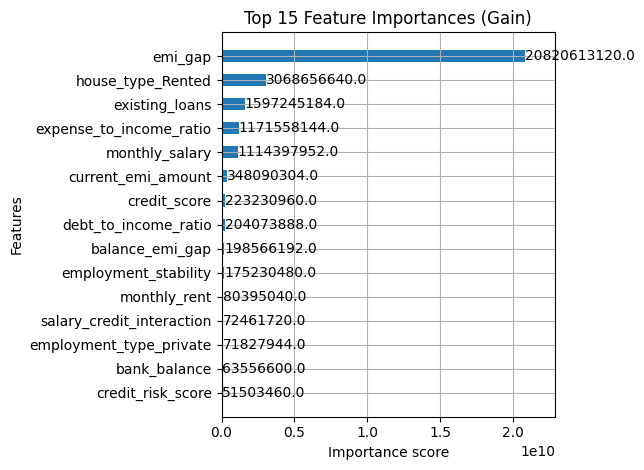

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

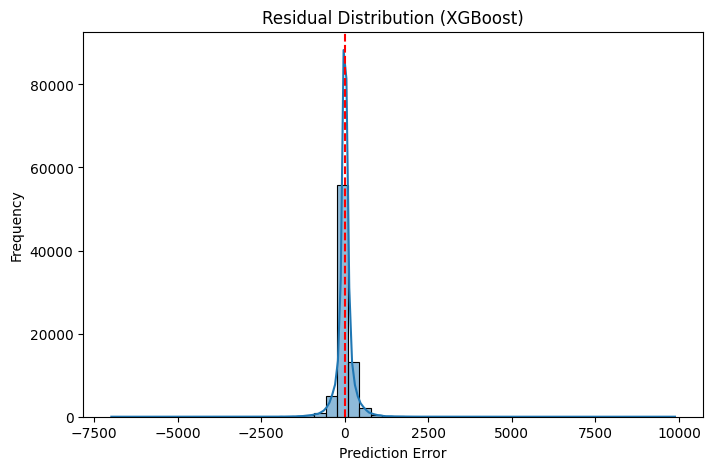

In [20]:
import seaborn as sns
import numpy as np

residuals = y_test_reg - y_pred_xgb

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)

grid.fit(X_train_reg, y_train_reg)
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


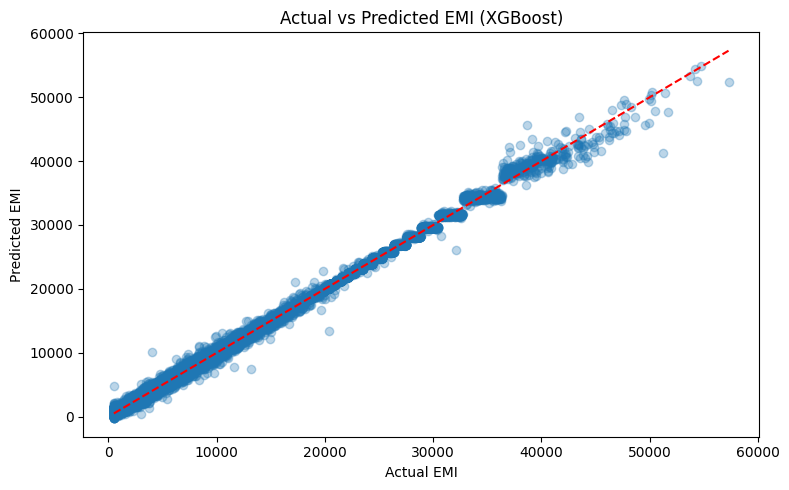

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, y_pred_xgb, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("Actual EMI")
plt.ylabel("Predicted EMI")
plt.title("Actual vs Predicted EMI (XGBoost)")
plt.tight_layout()
plt.show()